In [1]:
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset,random_split,DataLoader
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as T
import tifffile
import glob
from sklearn.model_selection import KFold
import segmentation_models_pytorch as smp
import albumentations
import cv2
import pywt
import albumentations as A
# Importing the U-Net model
from models import Unet
from dataset import *
from utils import *


c:\anaconda3\envs\master\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_paths_train, img_paths_val, img_paths_test, label_paths_train, label_paths_val, label_paths_test = create_splits(
        train_percentage=0.8,
        val_percentage=0.1,
        test_percentage=0.1,
        seed=42
        )

train_transforms = A.ReplayCompose(
    [
        A.RandomCrop(128, 128),
        A.RandomRotate90(),
        A.HorizontalFlip(),
        A.VerticalFlip()
    ], additional_targets={'mask': 'image'})

path = "C:/Users/The Son/Desktop/Uni/Berlin/Masterarbeit/Data/model_data/"
test_dataset = S2Dataset(img_paths_test, label_paths_test, data_path=path+"test", transforms=None, num_augmentations=0, dft_flag=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1, pin_memory=True, collate_fn=collate)


Train has 695 images and 695 labels
Val   has 87 images and 87 labels
Test  has 87 images and 87 labels


(4, 128, 128)
(24, 64, 64)


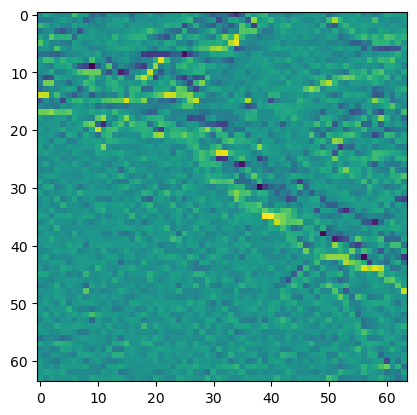

In [8]:
import pywt
def wavelet_transform(x, wavelet):
    target_size = x.shape
    coeffs2 = pywt.dwt2(x, wavelet)
    LL, (LH, HL, HH) = coeffs2
    LL = cv2.resize(LL, target_size, interpolation=cv2.INTER_LANCZOS4)
    LH = cv2.resize(LH, target_size, interpolation=cv2.INTER_LANCZOS4)
    HL = cv2.resize(HL, target_size, interpolation=cv2.INTER_LANCZOS4)
    HH = cv2.resize(HH, target_size, interpolation=cv2.INTER_LANCZOS4)
    return np.stack([LL, LH, HL, HH], axis=0)

path = "C:/Users/The Son/Desktop/Uni/Berlin/Masterarbeit/Data/model_data/train"
# Data/ms-dataset-chips\\95eff095-c3e9-4c12-bfde-1708b7e19bae\\s2\\S2A_MSIL1C_20170528T050611_N0205_R076_T44NNP_20170528T050606_00960-03063\\B12.tif'
data = np.load(f"{path}/1.npz", allow_pickle=True)
data = data["arr_0"][0]
X = data["image"]
mean = np.mean(X, axis=0)
wav = wavelet_transform(mean, "haar")
print(wav.shape)
plt.imshow(np.mean(X, axis=0))
X = torch.tensor(np.expand_dims(X, axis=0))

amps = data["amplitude"]

phases = data["wavelet"]
print(phases.shape)
plt.imshow(phases[1,:, :,])
#ap = torch.tensor(np.concatenate([amps, phases], axis=1)).cuda(non_blocking=True).float()
#print(ap.shape)
#print(np.mean(X).shape)


In [29]:
import torch
import pywt

def apply_full_wavelet_transform(input_tensor):
    batch_size, num_channels, _, _ = input_tensor.shape
    transformed_channels = []
    LL_ = []

    # Loop over the batch and each channel
    for i in range(batch_size):
        for j in range(num_channels):
            # Extract the single channel (shape [64, 64])
            single_channel = input_tensor[i, j, :, :].cpu().detach().numpy()
            
            # Apply wavelet transform (dwt2 for 2D)
            coeffs2 = pywt.dwt2(single_channel, "haar")
            LL, (LH, HL, HH) = coeffs2

            # Convert all components back to PyTorch tensors
            LL_tensor = torch.tensor(LL, dtype=torch.float32).to(input_tensor.device)
            LH_tensor = torch.tensor(LH, dtype=torch.float32).to(input_tensor.device)
            HL_tensor = torch.tensor(HL, dtype=torch.float32).to(input_tensor.device)
            HH_tensor = torch.tensor(HH, dtype=torch.float32).to(input_tensor.device)

            # Concatenate the four components along the channel dimension
            transformed = torch.cat((LL_tensor.unsqueeze(0), LH_tensor.unsqueeze(0), 
                                    HL_tensor.unsqueeze(0), HH_tensor.unsqueeze(0)), dim=0)

            # Append transformed tensor for this channel to the list
            LL_.append(LL_tensor)
            transformed_channels.append(transformed)

    # Stack all transformed channels and reshape to (batch_size, num_channels * 4, new_height, new_width)
    transformed_tensor = torch.stack(transformed_channels).view(batch_size, num_channels * 4, LL_tensor.shape[0], LL_tensor.shape[1])
    transformed_LL = torch.stack(LL_).view(batch_size, num_channels, LL_tensor.shape[0], LL_tensor.shape[1])

    return transformed_LL, transformed_tensor

# Example usage
input_tensor = torch.randn(6, 6, 64, 64)  # Your input tensor
LL, transformed_tensor = apply_full_wavelet_transform(input_tensor)

# Check the shape of the transformed tensor
print(transformed_tensor.shape)
print(LL.shape)

torch.Size([6, 24, 32, 32])
torch.Size([6, 6, 32, 32])


In [1]:
def normalize(image, mean, std):        
        return (image - mean) / std

def compute_amplitude_phase(self, image_channel):
        # Compute the 2D DFT of the channel
        dft = np.fft.fft2(image_channel)
        dft_shifted = np.fft.fftshift(dft)
        
        # Compute the amplitude spectrum
        amplitude_spectrum = np.abs(dft_shifted)
        
        # Compute the phase spectrum
        phase_spectrum = np.angle(dft_shifted)
        
        return amplitude_spectrum, phase_spectrum

def save_precomputed_data(transforms, output_dir="./test", data_paths=img_paths_test, mask_paths=label_paths_test, ):
    start_time = time.time()
    
    if not os.path.exists(output_dir):
        print("Creating data")        
        os.makedirs(output_dir, exist_ok=True)
        mean, std, amp_mean, amp_std, phase_mean, phase_std = i_, j_, a_m, a_s, p_, p_s
        
        for i, path in enumerate(data_paths):
            samples = []
            if isinstance(path, str):
                img = cv2.imread(path) / 255.0
            else:
                img = merge_tif(path)
            img = img.astype(np.float32)  # Ensure the image is in float32 format
            
            if img.ndim == 2:  # Single-channel image
                img = np.expand_dims(img, axis=-1)

            mask = tifffile.imread(mask_paths[i])    
            normalized_img = normalize(img, mean, std)
            replay_params = None
            if transforms:
                continue
            else:
                a, p = [], []
                for channel in img:
                    amp, phase = compute_amplitude_phase(channel)
                    a.append(amp)
                    p.append(phase)
                    plt.imshow(amp)

                normalized_amplitude = normalize(np.stack(a, axis=0), amp_mean, amp_std)
                normalized_phase = normalize(np.stack(p, axis=0), phase_mean, phase_std)

                sample = {
                    "image": normalized_img.transpose(2, 0, 1),
                    "amplitude": normalized_amplitude.transpose(2, 0, 1),
                    "phase": normalized_phase.transpose(2, 0, 1),
                    "mask": mask
                }
                samples.append(sample)
            output_path = f"{output_dir}/{i}.npz"
            np.savez(output_path, samples)
        print(f"Finished creating data {time.time() - start_time}")


NameError: name 'img_paths_test' is not defined

Creating data
(6, 512, 512) (6,)
Finished creating data 11.643087148666382


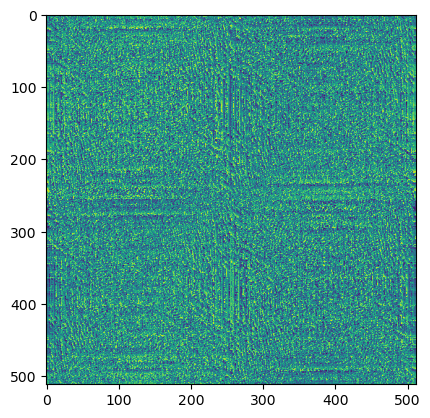

In [7]:
%reload_ext autoreload
test_dataset.data_classes[0].save_precomputed_data("./test")

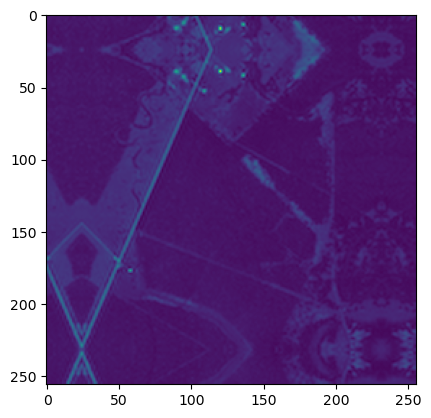

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Example usage:
# Assuming `input_image` is a tensor of shape [batch_size, 3, height, width]
# Normalize your input image as required by ResNet
# input_image = ... (your preprocessed image tensor)

# Loading data from precomputed dataset
path = "C:/Users/The Son/Desktop/Uni/Berlin/Masterarbeit/Data/model_data/train"
data = np.load(f"{path}/1.npz", allow_pickle=True)
data = data["arr_0"][0]
X = data["wavelet"]
plt.imshow(X[0, :, :])
X = data["image"]
#plt.imshow(X[2, :, :])
#X = torch.tensor(np.expand_dims(X, axis=0))



In [ ]:
def __getitem__(self, idx):
    replay_params = None
    mask = None
    sample = []
    for i, c in enumerate(self.data_classes):
        mask = tifffile.imread(self.mask_paths[idx])
        if c.data_paths[idx].endswith(".tif"):
            img = tifffile.imread(c.data_paths[idx])
        elif c.data_paths[idx].endswith(".png"):
            img = cv2.imread(c.data_paths[idx]) / 255.0
        if img.ndim == 2:  # Single-channel image
            img = np.expand_dims(img, axis=-1)
        normalized_img = self.normalize(img, c.mean, c.std)
        if self.transforms:
            if replay_params == None:
                augmented_samples, mask, replay_params = self.apply_augmentations(normalized_img, mask)
            else:
                # Replay augmentations for subsequent images
                augmented_samples, mask = self.replay_augmentations(normalized_img, mask, replay_params)

            data = dict()
            # Create amplitude and phase spectrum for every augmentation
            for i, augmented_img in enumerate(augmented_samples):
                a, p = [], []
                for channel in augmented_img:  # Iterate over channels
                    amp, phase = c.compute_amplitude_phase(channel)
                    a.append(amp)
                    p.append(phase)
                # Stack amplitude and phase along the channel dimension
                augmented_amplitude = self.normalize(np.stack(a, axis=0), c.amp_mean, c.amp_std)
                augmented_phase = self.normalize(np.stack(p, axis=0), c.phase_mean, c.phase_std)
                # Combine amplitude and phase into a single array and change to C,H,W
                data["image"] = augmented_img.transpose(2, 0, 1)
                data["amplitude"] = augmented_amplitude.transpose(2, 0, 1)
                data["phase"] = augmented_phase.transpose(2, 0, 1)
                data["mask"] = mask[i]
            sample.append(data)
            continue
        # If no transforms needed
        data = dict()
        a, p = [], []
        for channel in normalized_img:  # Iterate over channels
            amp, phase = c.compute_amplitude_phase(channel)
            a.append(amp)
            p.append(phase)
        # Stack amplitude and phase along the channel dimension
        normalized_amplitude = self.normalize(np.stack(a, axis=0), c.amp_mean, c.amp_std)
        normalized_phase = self.normalize(np.stack(p, axis=0), c.phase_mean, c.phase_std)
        data["image"] = normalized_img.transpose(2, 0, 1)
        data["amplitude"] = normalized_amplitude.transpose(2, 0, 1)
        data["phase"] = normalized_phase.transpose(2, 0, 1)
        data["mask"] = mask
        sample.append(data)
        continue
    return sample

In [ ]:
import torch
import tifffile
import numpy as np
import cv2
import glob

class Sentinel2_Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        img_paths,
        mask_paths,
        transforms=None,
        seed=1337,
        num_augmentations=4,
        dft_flag=True,
    ):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transforms = transforms
        self.dft_flag = dft_flag
        self.seed = seed
        self.num_augmentations = num_augmentations
        self.mean, self.std, self.amp_mean, self.amp_std, self.phase_mean, self.phase_std = self.get_dataset_mean_std()
        self.dim = self.get_dim()


    def get_dim(self):
        if self.dft_flag:
            return len(np.ravel(self.mean)) + len(np.ravel(self.amp_mean)) + len(np.ravel(self.phase_mean))
        else:
            return len(np.ravel(self.mean))

    def get_dataset_mean_std(self):
        """
        Computes the channelwise mean and std of the dataset incrementally
        """
        n_images = 0
        mean, M2 = None, None
        amp_mean, amp_M2 = None, None
        phase_mean, phase_M2 = None, None
        means, stds, amp_means, amp_stds, phase_means, phase_stds = [], [], [], [], [], []

        for path_list in self.img_paths:
            for path in path_list:
                if path.endswith(".tif"):
                    img = tifffile.imread(path)
                elif path.endswith(".png"):
                    img = cv2.imread(path) / 255.0
                else:
                    continue  # Skip unsupported file types

                img = img.astype(np.float32)  # Ensure the image is in float32 format

                if img.ndim == 2:  # Single-channel image
                    img = np.expand_dims(img, axis=-1)

                a, p = [], []
                for channel in img.transpose(2, 0, 1):  # Iterate over channels
                    amp, phase = self.compute_amplitude_phase(channel)
                    a.append(amp)
                    p.append(phase)

                a = np.array(a)
                p = np.array(p)

                n_images += 1

                if n_images == 1:
                    mean = np.mean(img, axis=(0, 1))
                    M2 = np.zeros_like(mean)
                    amp_mean = np.mean(a, axis=(1, 2))
                    amp_M2 = np.zeros_like(amp_mean)
                    phase_mean = np.mean(p, axis=(1, 2))
                    phase_M2 = np.zeros_like(phase_mean)
                else:
                    img_mean = np.mean(img, axis=(0, 1))
                    delta = img_mean - mean
                    mean += delta / n_images
                    M2 += delta * (img_mean - mean)

                    amp_img_mean = np.mean(a, axis=(1, 2))
                    delta_amp = amp_img_mean - amp_mean
                    amp_mean += delta_amp / n_images
                    amp_M2 += delta_amp * (amp_img_mean - amp_mean)

                    phase_img_mean = np.mean(p, axis=(1, 2))
                    delta_phase = phase_img_mean - phase_mean
                    phase_mean += delta_phase / n_images
                    phase_M2 += delta_phase * (phase_img_mean - phase_mean)

            if n_images > 1:
                std = np.sqrt(M2 / (n_images - 1))
                amp_std = np.sqrt(amp_M2 / (n_images - 1))
                phase_std = np.sqrt(phase_M2 / (n_images - 1))
            else:
                std, amp_std, phase_std = [np.zeros_like(mean)] * 3
            means.append(mean)
            stds.append(std)
            amp_means.append(amp_mean)
            amp_stds.append(amp_std)
            phase_means.append(phase_mean)
            phase_stds.append(phase_std)
        print("Finished computing means and stds")
        print(means, stds, amp_means, amp_stds, phase_means, phase_stds)
        return means, stds, amp_means, amp_stds, phase_means, phase_stds
    
    def get_pwater_mean_std(self):
        """
        Computes the mean and std of pwater data
        """
        pwater_paths = [path.replace("LabelWater.tif", f"LabelWater_jrc-gsw-occurrence.tif") for path in self.mask_paths]
        images = []
        for path in pwater_paths:
            img = tifffile.imread(path)
            images.append(img / 100.0)
        return np.mean(images), np.std(images)

    def normalize_data(self, image, index, epsilon=1e-6):
        mean = self.mean[index]
        std = self.std[index]
        normalized_image = (image - mean) / (std)
        return normalized_image
    
    def normalize_amp_phase(self, amp, phase, index, epsilon=1e-6):
        amp_mean = self.amp_mean[index]
        amp_std = self.amp_std[index]

        phase_mean = self.phase_mean[index]
        phase_std = self.phase_std[index]

        normalized_amp = (amp - amp_mean) / (amp_std)
        normalized_phase = (phase - phase_mean) / (phase_std)
        return normalized_amp, normalized_phase
    
    def normalize_pwater(self, image, epsilon=1e-6):
        return (image - self.pwater_mean) / (self.pwater_std)
    

    def compute_amplitude_phase(self, image_channel):
        # Compute the 2D DFT of the channel
        dft = np.fft.fft2(image_channel)
        dft_shifted = np.fft.fftshift(dft)
        
        # Compute the amplitude spectrum
        amplitude_spectrum = np.abs(dft_shifted)
        
        # Compute the phase spectrum
        phase_spectrum = np.angle(dft_shifted)
        
        return amplitude_spectrum, phase_spectrum
    
    def __getitem__(self, idx):
        # Load in image
        arr_x = []
        for i, path_list in enumerate(self.img_paths):
            if path_list[idx].endswith(".tif"):
                img = tifffile.imread(path_list[idx])
            elif path_list[idx].endswith(".png"):
                img = cv2.imread(path_list[idx]) / 255.0
            img_norm = self.normalize_data(img, i)
            arr_x.append(img_norm)
        arr_x = np.concatenate(arr_x, axis=-1)
        #pwater = tifffile.imread(self.mask_paths[idx].replace("LabelWater.tif", f"LabelWater_jrc-gsw-occurrence.tif"))
        #pwater = self.normalize_pwater(pwater / 100.0)
        #pwater = np.expand_dims(pwater, axis=-1)
        #arr_x = np.concatenate((arr_x, pwater), axis=-1)

        sample = {"image": arr_x}
        # Load in label mask
        sample["mask"] = tifffile.imread(self.mask_paths[idx])

        # Apply Data Augmentation
        if self.transforms:
            augmented_samples = []
            for _ in range(self.num_augmentations):
                augmented_sample = self.transforms(image=sample["image"], mask=sample["mask"])
                augmented_samples.append(augmented_sample)
                if augmented_sample["image"].shape[-1] < 20:
                    augmented_sample["image"] = augmented_sample["image"].transpose((2, 0, 1))
            if self.dft_flag:
                augmented_samples_with_spectra = []
                for augmented_sample in augmented_samples:
                    # Extract image and compute amplitude and phase
                    img = augmented_sample["image"].transpose((1, 2, 0))  # Convert back to HWC format
                    amplitude_channels = []
                    phase_channels = []
                    for c in img:
                        amplitude, phase = self.compute_amplitude_phase(c)
                        amplitude_channels.append(amplitude)
                        phase_channels.append(phase)

                    # Normalize amplitude and phase spectra
                    amplitude_channels = np.stack(amplitude_channels, axis=-1).transpose((2, 0, 1))
                    phase_channels = np.stack(phase_channels, axis=-1).transpose((2, 0, 1))
                    amplitude_channels, phase_channels = self.normalize_amp_phase(amplitude_channels, phase_channels, )

                    # Append amplitude and phase to the augmented image
                    augmented_image_with_spectra = np.concatenate([img, amplitude_channels, phase_channels], axis=-1)
                    augmented_sample["image"] = augmented_image_with_spectra.transpose((2, 0, 1))  # Convert back to CHW format
                    augmented_samples_with_spectra.append(augmented_sample)
                return augmented_samples_with_spectra
            else:
                return augmented_samples
        
        # Compute amplitude and phase for each channel in the original image
        img = arr_x
        if self.dft_flag:
            amplitude_channels = []
            phase_channels = []
            for i, c in enumerate(img):
                amplitude, phase = self.normalize_amp_phase(*self.compute_amplitude_phase(c), i)
                amplitude_channels.append(amplitude)
                phase_channels.append(phase)

            # Normalize amplitude and phase spectra
            amplitude_channels = np.stack(amplitude_channels, axis=-1).transpose((2, 0, 1))
            phase_channels = np.stack(phase_channels, axis=-1).transpose((2, 0, 1))

            # Append amplitude and phase to the original image
            arr_x_with_spectra = np.concatenate([arr_x, amplitude_channels, phase_channels], axis=-1)
            sample["image"] = arr_x_with_spectra.transpose((2, 0, 1))  # Convert to CHW format
        if sample["image"].shape[-1] < 20:
            sample["image"] = sample["image"].transpose((2, 0, 1))
        return sample

    def __len__(self):
        return len(self.mask_paths)

            
def mask_to_img(label, color_dict):
    """Recodes a (H,W) mask to a (H,W,3) RGB image according to color_dict"""
    mutually_exclusive = np.zeros(label.shape + (3,), dtype=np.uint8)
    for key in range(1, len(color_dict.keys()) + 1):
        mutually_exclusive[label == key] = color_dict[key]
    return mutually_exclusive



def get_paths(fraction=1, bands=["B8.tif", "B12.tif"], seed=1337):
    """
    Returns:
        label_paths: list of all labelpaths
        bands_paths: list of lists containing paths to databands [[Bandpaths1], .., [BandpathsN]]
    """
    label_paths = sorted(glob.glob("Data/ms-dataset-chips/*/s2/*/LabelWater.tif"))
    filtered_paths = []
    # Only select labels, where there is more than 50% of information
    for png in label_paths:
        path = png.replace("LabelWater.tif", bands[0])
        flat_img = np.ravel(cv2.imread(path))
        if np.sum(flat_img == 0) / len(flat_img) <= 0.5:
            filtered_paths.append(png)

    label_paths = filtered_paths[:int(len(filtered_paths)*fraction)]

    np.random.seed(seed)
    np.random.shuffle(label_paths)

    bands_paths = []
    for band in bands:
        band_path_list = []
        for path in label_paths:
            band_path_list.append(path.replace("LabelWater.tif", f"{band}"))
        bands_paths.append(band_path_list)
    return label_paths, bands_paths


def create_splits(train_percentage=0.4, val_percentage=0.3, test_percentage=0.3, seed=1337):
    label_paths, img_paths = get_paths(fraction=0.2, seed=seed, bands=["SWIRP.png", "SWIR.png"])

    img_paths_train = [row[: int(train_percentage * len(label_paths))] for row in img_paths]
    img_paths_val = [row[int(train_percentage * len(label_paths)): int((train_percentage + val_percentage) * len(label_paths))] for row in img_paths]
    img_paths_test = [row[int((train_percentage + val_percentage) * len(label_paths)):] for row in img_paths]

    label_paths_train = label_paths[: int(train_percentage * len(label_paths))]
    label_paths_val = label_paths[int(train_percentage * len(label_paths)): int((train_percentage + val_percentage) * len(label_paths))]
    label_paths_test = label_paths[int((train_percentage + val_percentage) * len(label_paths)):]

    print(f"Train has {len(img_paths_train[0])} images and {len(label_paths_train)} labels")
    print(f"Val   has {len(img_paths_val[0])} images and {len(label_paths_val)} labels")
    print(f"Test  has {len(img_paths_test[0])} images and {len(label_paths_test)} labels")
    return img_paths_train, img_paths_val, img_paths_test, label_paths_train, label_paths_val, label_paths_test


img_paths_train, img_paths_val, img_paths_test, label_paths_train, label_paths_val, label_paths_test = create_splits(
        train_percentage=0.5,
        val_percentage=0.25,
        test_percentage=0.25,
        seed=1
        )
print(img_paths_test[0][0].split('\\')[-1])

Train has 86 images and 86 labels
Val   has 43 images and 43 labels
Test  has 44 images and 44 labels
SWIRP.png


(257, 257)
(267, 267)
(286, 286)


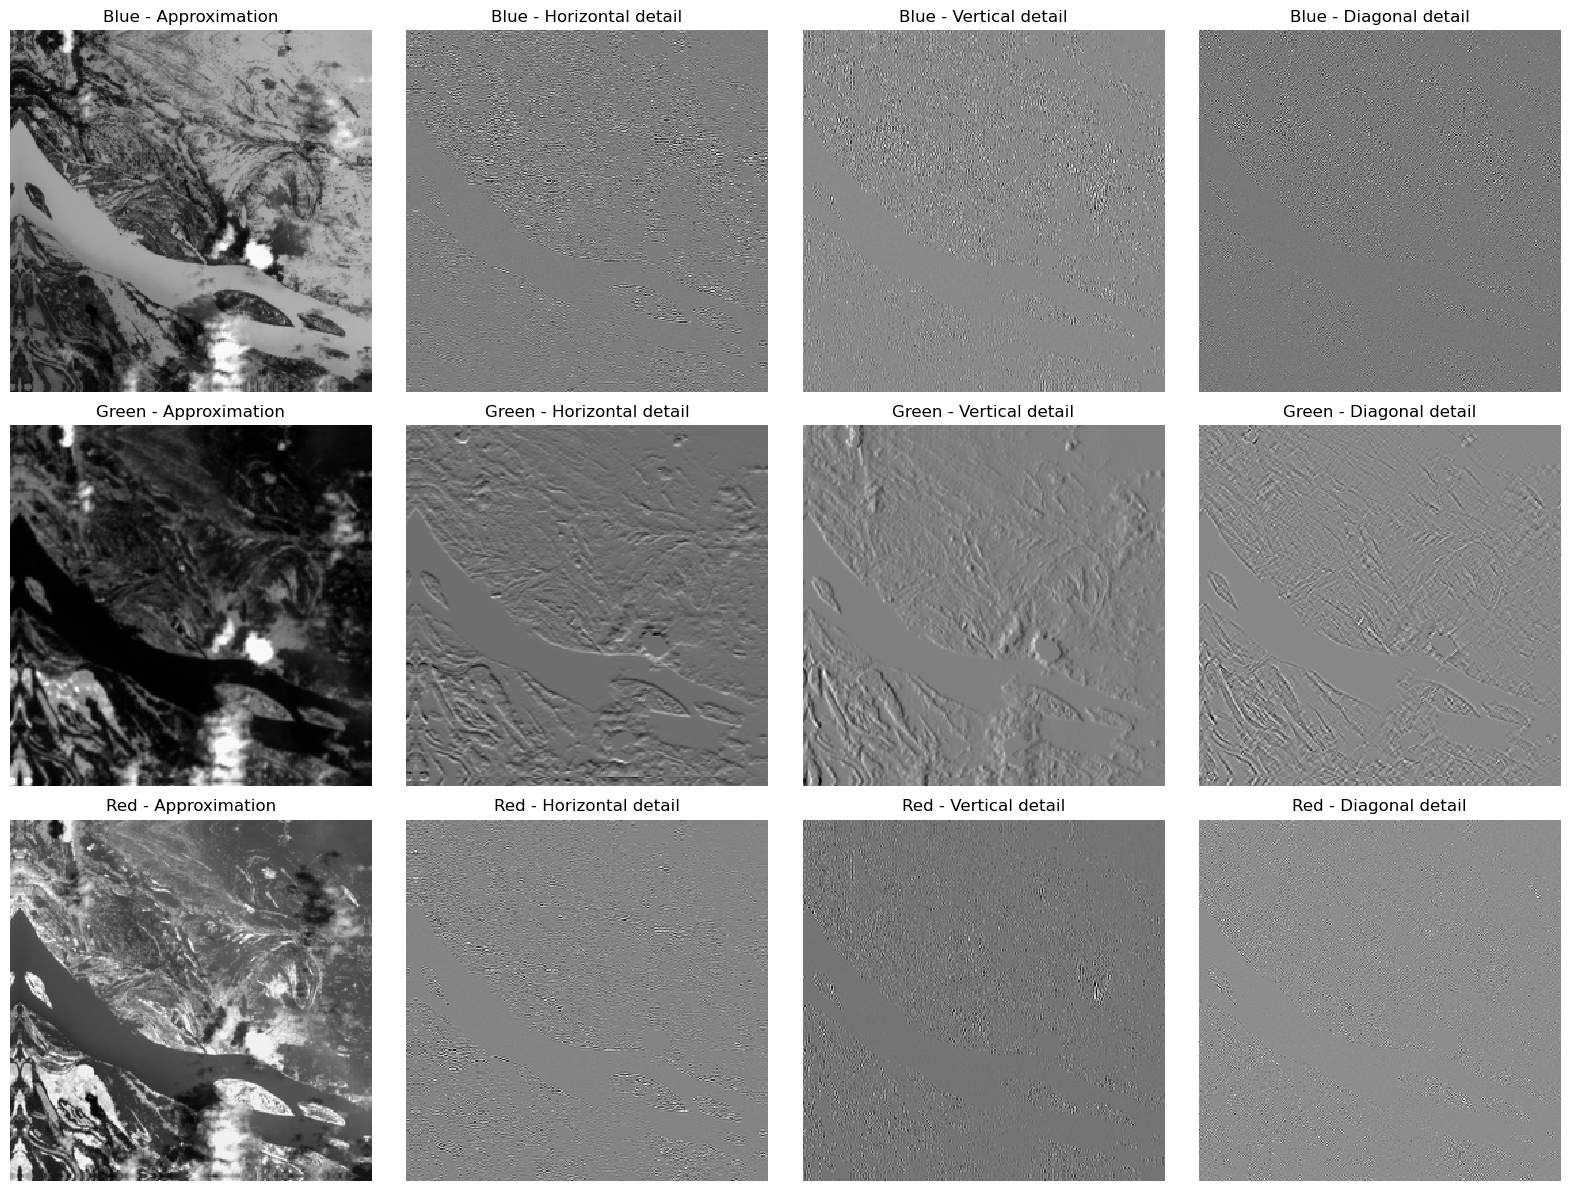

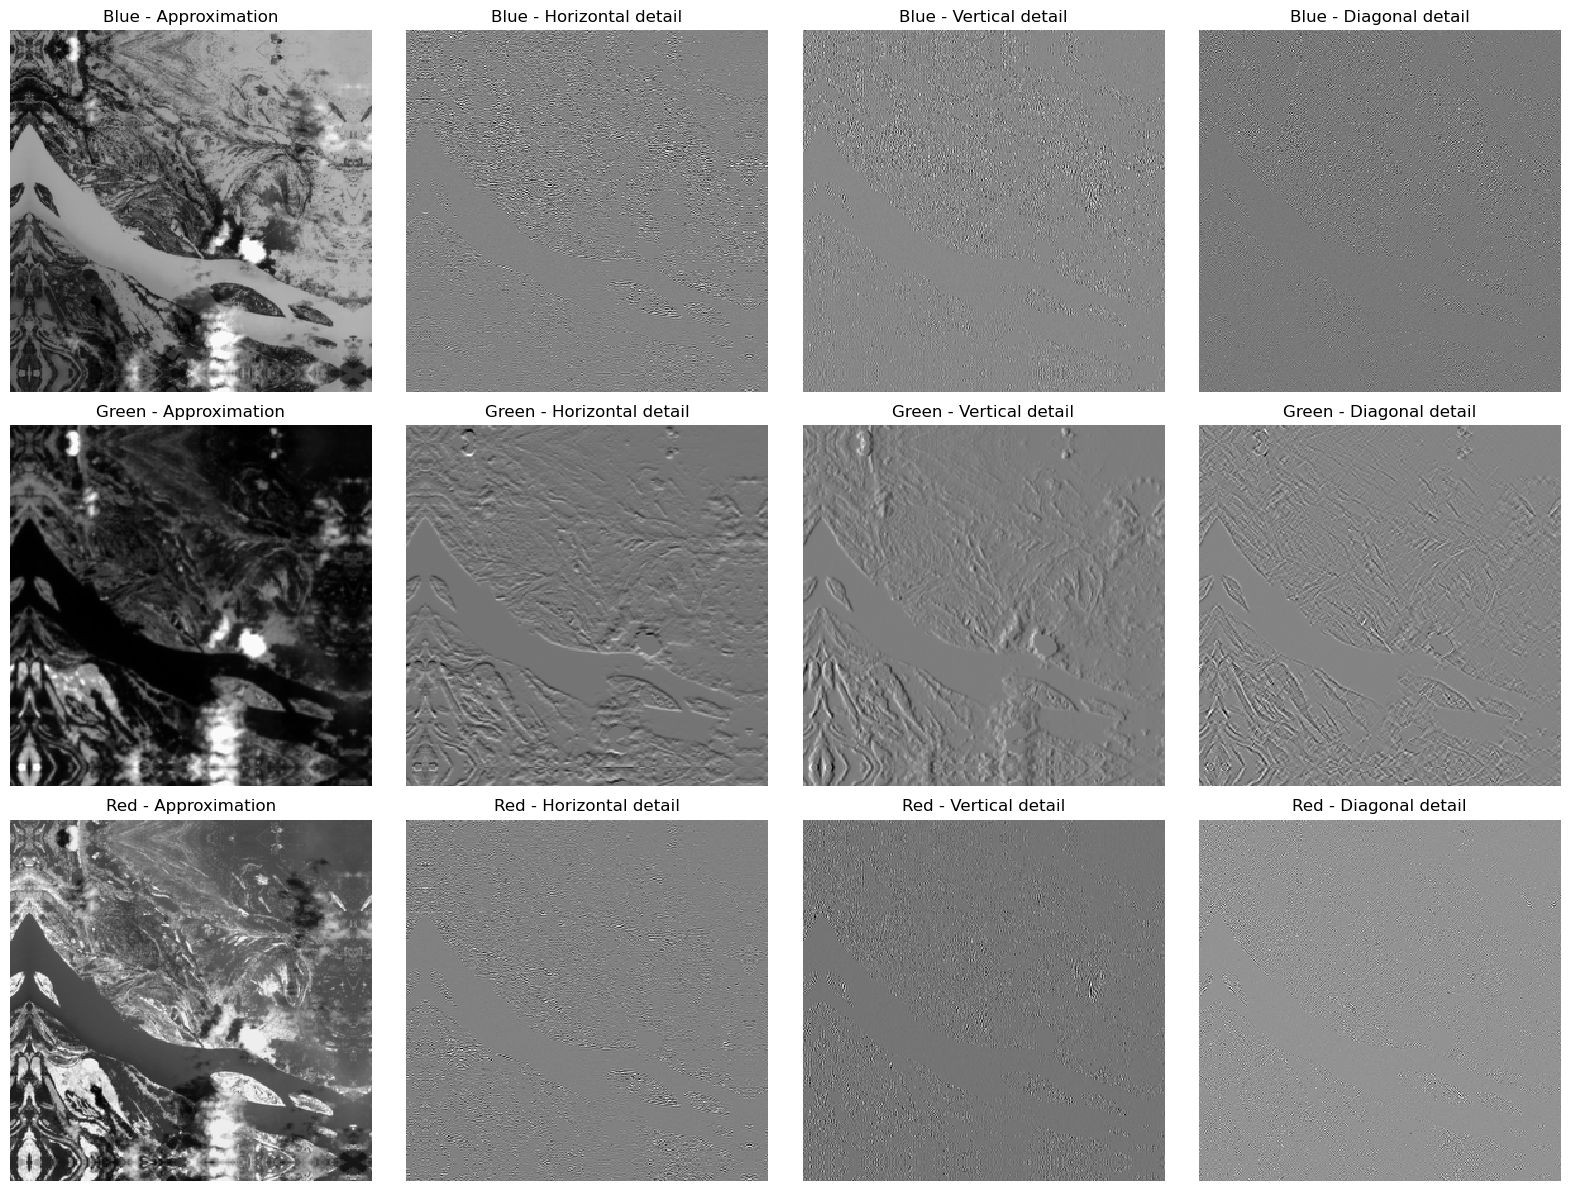

In [6]:

image_color = cv2.imread("./SWIRP.png")

# Split the image into its color channels
b_channel, g_channel, r_channel = cv2.split(image_color)

# Perform Haar wavelet transform on each channel
coeffs_b = pywt.dwt2(b_channel, 'db2')
coeffs_g = pywt.dwt2(g_channel, 'db2')
coeffs_r = pywt.dwt2(r_channel, 'db2')

LL_b, (LH_b, HL_b, HH_b) = coeffs_b
print(LL_b.shape)
LL_g, (LH_g, HL_g, HH_g) = coeffs_g
LL_r, (LH_r, HL_r, HH_r) = coeffs_r
# Perform Daubechies (db4) wavelet transform on each channel
coeffs_b_db4 = pywt.dwt2(b_channel, 'coif4')
coeffs_g_db4 = pywt.dwt2(g_channel, 'coif4')
coeffs_r_db4 = pywt.dwt2(r_channel, 'coif4')

LL_b_db4, (LH_b_db4, HL_b_db4, HH_b_db4) = coeffs_b_db4
print(LL_b_db4.shape)
LL_g_db4, (LH_g_db4, HL_g_db4, HH_g_db4) = coeffs_g_db4
LL_r_db4, (LH_r_db4, HL_r_db4, HH_r_db4) = coeffs_r_db4

# Perform Discrete Meyer (dmey) wavelet transform on each channel
coeffs_b_dmey = pywt.dwt2(b_channel, 'dmey')
coeffs_g_dmey = pywt.dwt2(g_channel, 'dmey')
coeffs_r_dmey = pywt.dwt2(r_channel, 'dmey')

LL_b_dmey, (LH_b_dmey, HL_b_dmey, HH_b_dmey) = coeffs_b_dmey
print(LL_b_dmey.shape)
LL_g_dmey, (LH_g_dmey, HL_g_dmey, HH_g_dmey) = coeffs_g_dmey
LL_r_dmey, (LH_r_dmey, HL_r_dmey, HH_r_dmey) = coeffs_r_dmey

# Plot the results for Daubechies (db4)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
coeffs_db4 = [(LL_b_db4, LH_b_db4, HL_b_db4, HH_b_db4), (LL_g_db4, LH_g_db4, HL_g_db4, HH_g_db4), (LL_r_db4, LH_r_db4, HL_r_db4, HH_r_db4)]
titles_db4 = ['Blue - Approximation', 'Blue - Horizontal detail', 'Blue - Vertical detail', 'Blue - Diagonal detail',
              'Green - Approximation', 'Green - Horizontal detail', 'Green - Vertical detail', 'Green - Diagonal detail',
              'Red - Approximation', 'Red - Horizontal detail', 'Red - Vertical detail', 'Red - Diagonal detail']

for i, (LL, LH, HL, HH) in enumerate(coeffs_db4):
    axes[i, 0].imshow(LL, interpolation="nearest", cmap=plt.cm.gray)
    axes[i, 0].set_title(titles_db4[i*4])
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(LH, interpolation="nearest", cmap=plt.cm.gray)
    axes[i, 1].set_title(titles_db4[i*4+1])
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(HL, interpolation="nearest", cmap=plt.cm.gray)
    axes[i, 2].set_title(titles_db4[i*4+2])
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(HH, interpolation="nearest", cmap=plt.cm.gray)
    axes[i, 3].set_title(titles_db4[i*4+3])
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

# Plot the results for Discrete Meyer (dmey)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
coeffs_dmey = [(LL_b_dmey, LH_b_dmey, HL_b_dmey, HH_b_dmey), (LL_g_dmey, LH_g_dmey, HL_g_dmey, HH_g_dmey), (LL_r_dmey, LH_r_dmey, HL_r_dmey, HH_r_dmey)]
titles_dmey = ['Blue - Approximation', 'Blue - Horizontal detail', 'Blue - Vertical detail', 'Blue - Diagonal detail',
               'Green - Approximation', 'Green - Horizontal detail', 'Green - Vertical detail', 'Green - Diagonal detail',
               'Red - Approximation', 'Red - Horizontal detail', 'Red - Vertical detail', 'Red - Diagonal detail']

for i, (LL, LH, HL, HH) in enumerate(coeffs_dmey):
    axes[i, 0].imshow(LL, interpolation="nearest", cmap=plt.cm.gray)
    axes[i, 0].set_title(titles_dmey[i*4])
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(LH, interpolation="nearest", cmap=plt.cm.gray)
    axes[i, 1].set_title(titles_dmey[i*4+1])
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(HL, interpolation="nearest", cmap=plt.cm.gray)
    axes[i, 2].set_title(titles_dmey[i*4+2])
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(HH, interpolation="nearest", cmap=plt.cm.gray)
    axes[i, 3].set_title(titles_dmey[i*4+3])
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()


In [ ]:

class Sentinel2_Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        img_paths,
        mask_paths,
        transforms=None,
        seed=1337,
        num_augmentations=4
    ):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transforms = transforms
        self.dim = 6
        self.seed = seed
        self.num_augmentations = num_augmentations
        self.mean, self.std, self.amp_mean, self.amp_std, self.phase_mean, self.phase_std = self.get_dataset_mean_std()
        
        #self.pwater_mean, self.pwater_std = self.get_pwater_mean_std()

    def get_dataset_mean_std(self):
        """
        Computes the channelwise mean and std of the dataset
        """
        means = []
        stds = []
        amp_means, amp_stds, phase_means, phase_stds = [], [], [], []
        all_amplitudes = []
        all_phases = []

        for path_list in self.img_paths:
            images = []
            a = []
            p = []
            amplitudes = []
            phases = []
            for path in path_list:
                if ".tif" in path:
                    img = tifffile.imread(path)
                elif ".png" in path:
                    img = cv2.imread(path) / 255.0
                    images.append(img)
                for channel in img:
                    amp, phase = self.compute_amplitude_phase(channel)
                    a.append(amp)
                    p.append(phase)
                amplitudes = np.stack(a, axis=-1).transpose((0, 2, 1))
                phases = np.stack(p, axis=-1).transpose((0, 2, 1))
                all_amplitudes.append(amplitudes)
                all_phases.append(phases)

            amp_means.append(np.mean(all_amplitudes, axis=(0, 1, 2)))
            amp_stds.append(np.std(all_amplitudes, axis=(0, 1, 2)))
            phase_means.append(np.mean(all_phases, axis=(0, 1, 2)))
            phase_stds.append(np.std(all_phases,  axis=(0, 1, 2)))

            means.append(np.mean(images, axis=(0, 1, 2)))
            stds.append(np.std(images, axis=(0, 1, 2)))
        
        return means, stds, amp_means, amp_stds, phase_means, phase_stds
    
    def get_pwater_mean_std(self):
        """
        Computes the mean and std of pwater data
        """
        pwater_paths = [path.replace("LabelWater.tif", f"LabelWater_jrc-gsw-occurrence.tif") for path in self.mask_paths]
        images = []
        for path in pwater_paths:
            img = tifffile.imread(path)
            images.append(img / 100.0)
        return np.mean(images), np.std(images)

    def normalize_data(self, image, index, epsilon=1e-6):
        mean = self.mean[index]
        std = self.std[index]
        normalized_image = (image - mean) / (std)
        return normalized_image
    
    def normalize_pwater(self, image, epsilon=1e-6):
        return (image - self.pwater_mean) / (self.pwater_std)
    

    def compute_amplitude_phase(self, image_channel):
        # Compute the 2D DFT of the channel
        dft = np.fft.fft2(image_channel)
        dft_shifted = np.fft.fftshift(dft)
        
        # Compute the amplitude spectrum
        amplitude_spectrum = np.abs(dft_shifted)
        
        # Compute the phase spectrum
        phase_spectrum = np.angle(dft_shifted)
        
        return amplitude_spectrum, phase_spectrum
    
    def __getitem__(self, idx):
        # Load in image
        arr_x = []
        for i, path_list in enumerate(self.img_paths):
            img = cv2.imread(path_list[idx])
            img = img / 255.0
            img_norm = self.normalize_data(img, i)
            arr_x.append(img_norm)
        arr_x = np.concatenate(arr_x, axis=-1)
        #pwater = tifffile.imread(self.mask_paths[idx].replace("LabelWater.tif", f"LabelWater_jrc-gsw-occurrence.tif"))
        #pwater = self.normalize_pwater(pwater / 100.0)
        #pwater = np.expand_dims(pwater, axis=-1)
        #arr_x = np.concatenate((arr_x, pwater), axis=-1)

        sample = {"image": arr_x}
        self.dim = arr_x.shape[-1]
        # Load in label mask
        sample["mask"] = tifffile.imread(self.mask_paths[idx])

        # Apply Data Augmentation
        if self.transforms:
            augmented_samples = []
            for _ in range(self.num_augmentations):
                #augmented_sample = sample.copy()
                augmented_sample = self.transforms(image=sample["image"], mask=sample["mask"])
                augmented_samples.append(augmented_sample)
                if augmented_sample["image"].shape[-1] < 20:
                    augmented_sample["image"] = augmented_sample["image"].transpose((2, 0, 1))

            augmented_samples_with_spectra = []
            for augmented_sample in augmented_samples:
                # Extract image and compute amplitude and phase
                img = augmented_sample["image"].transpose((1, 2, 0))  # Convert back to HWC format
                amplitude_channels = []
                phase_channels = []
                for c in img:
                    amplitude, phase = self.compute_amplitude_phase(c)
                    amplitude_channels.append(amplitude)
                    phase_channels.append(phase)

                # Normalize amplitude and phase spectra
                amplitude_channels = np.stack(amplitude_channels, axis=-1).transpose((2, 0, 1))
                phase_channels = np.stack(phase_channels, axis=-1).transpose((2, 0, 1))

                # Append amplitude and phase to the augmented image
                augmented_image_with_spectra = np.concatenate([img, amplitude_channels, phase_channels], axis=-1)
                augmented_sample["image"] = augmented_image_with_spectra.transpose((2, 0, 1))  # Convert back to CHW format
                augmented_samples_with_spectra.append(augmented_sample)
            return augmented_samples_with_spectra
        
        # Compute amplitude and phase for each channel in the original image
        img = arr_x
        amplitude_channels = []
        phase_channels = []
        for c in img:
            amplitude, phase = self.compute_amplitude_phase(c)
            amplitude_channels.append(amplitude)
            phase_channels.append(phase)

        # Normalize amplitude and phase spectra
        amplitude_channels = np.stack(amplitude_channels, axis=-1).transpose((2, 0, 1))
        phase_channels = np.stack(phase_channels, axis=-1).transpose((2, 0, 1))

        # Append amplitude and phase to the original image
        arr_x_with_spectra = np.concatenate([arr_x, amplitude_channels, phase_channels], axis=-1)
        sample["image"] = arr_x_with_spectra.transpose((2, 0, 1))  # Convert to CHW format

        if sample["image"].shape[-1] < 20:
            sample["image"] = sample["image"].transpose((2, 0, 1))
        return sample

    def __len__(self):
        return len(self.mask_paths)

            
def mask_to_img(label, color_dict):
    """Recodes a (H,W) mask to a (H,W,3) RGB image according to color_dict"""
    mutually_exclusive = np.zeros(label.shape + (3,), dtype=np.uint8)
    for key in range(1, len(color_dict.keys()) + 1):
        mutually_exclusive[label == key] = color_dict[key]
    return mutually_exclusive



def get_paths(fraction=1, bands=["SWIRP.png"], seed=1337):
    """
    Returns:
        label_paths: list of all labelpaths
        bands_paths: list of lists containing paths to databands [[Bandpaths1], .., [BandpathsN]]
    """
    label_paths = sorted(glob.glob("Data/ms-dataset-chips/*/s2/*/LabelWater.tif"))
    filtered_paths = []
    # Only select labels, where there is more than 50% of information
    for png in label_paths:
        path = png.replace("LabelWater.tif", bands[0])
        flat_img = np.ravel(cv2.imread(path))
        if np.sum(flat_img == 0) / len(flat_img) <= 0.5:
            filtered_paths.append(png)

    label_paths = filtered_paths[:int(len(filtered_paths)*fraction)]

    np.random.seed(seed)
    np.random.shuffle(label_paths)

    bands_paths = []
    for band in bands:
        band_path_list = []
        for path in label_paths:
            band_path_list.append(path.replace("LabelWater.tif", f"{band}"))
        bands_paths.append(band_path_list)
    return label_paths, bands_paths


def create_splits(train_percentage=0.4, val_percentage=0.3, test_percentage=0.3):
    label_paths, img_paths = get_paths(fraction=1)

    img_paths_train = [row[: int(train_percentage * len(label_paths))] for row in img_paths]
    img_paths_val = [row[int(train_percentage * len(label_paths)): int((train_percentage + val_percentage) * len(label_paths))] for row in img_paths]
    img_paths_test = [row[int((train_percentage + val_percentage) * len(label_paths)):] for row in img_paths]

    label_paths_train = label_paths[: int(train_percentage * len(label_paths))]
    label_paths_val = label_paths[int(train_percentage * len(label_paths)): int((train_percentage + val_percentage) * len(label_paths))]
    label_paths_test = label_paths[int((train_percentage + val_percentage) * len(label_paths)):]

    print(f"Train has {len(img_paths_train[0])} images and {len(label_paths_train)} labels")
    print(f"Val   has {len(img_paths_val[0])} images and {len(label_paths_val)} labels")
    print(f"Test  has {len(img_paths_test[0])} images and {len(label_paths_test)} labels")
    return img_paths_train, img_paths_val, img_paths_test, label_paths_train, label_paths_val, label_paths_test

img_paths_train, img_paths_val, img_paths_test, label_paths_train, label_paths_val, label_paths_test = create_splits()

train_transforms = albumentations.Compose(
    [
        albumentations.RandomCrop(128, 128),
        albumentations.RandomRotate90(),
        albumentations.HorizontalFlip(),
        albumentations.VerticalFlip()
    ]
)

train_dataset = Sentinel2_Dataset(img_paths_train, label_paths_train, transforms=train_transforms, num_augmentations=2)

Train has 346 images and 346 labels
Val   has 260 images and 260 labels
Test  has 260 images and 260 labels


MemoryError: Unable to allocate 60.0 MiB for an array with shape (512, 3, 5120) and data type float64

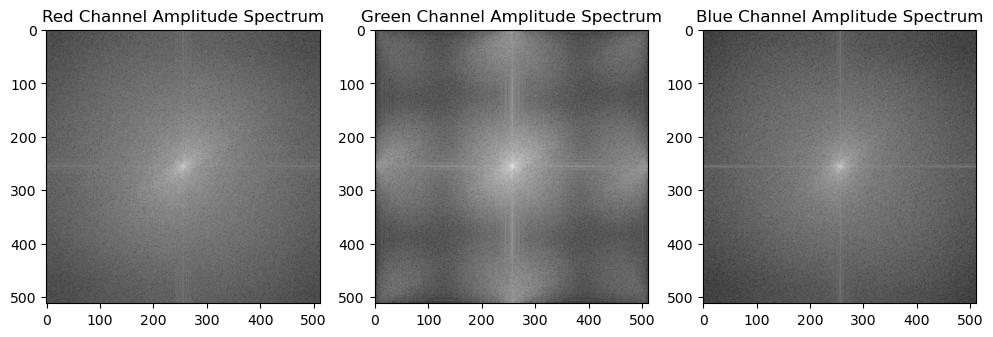

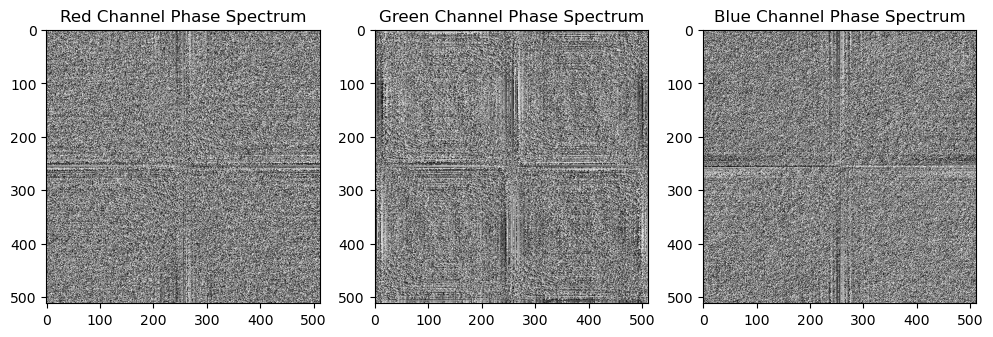

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pywavelet as wavelet
# Load the image
image = Image.open('./SWIRP.png')
image = np.array(image)
# Separate the channels
red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]

# Function to compute DFT, amplitude, and phase
def compute_dft_amplitude_phase(channel):
    # Compute the DFT
    dft = np.fft.fft2(channel)
    dft_shifted = np.fft.fftshift(dft)
    
    # Compute the amplitude spectrum
    amplitude_spectrum = np.abs(dft_shifted)
    
    # Compute the phase spectrum
    phase_spectrum = np.angle(dft_shifted)
    
    return amplitude_spectrum, phase_spectrum

# Compute amplitude and phase for each channel
amplitude_red, phase_red = compute_dft_amplitude_phase(red_channel)
amplitude_green, phase_green = compute_dft_amplitude_phase(green_channel)
amplitude_blue, phase_blue = compute_dft_amplitude_phase(blue_channel)

# Plot the amplitude spectra
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(np.log(1 + amplitude_red), cmap='gray')
plt.title('Red Channel Amplitude Spectrum')

plt.subplot(132)
plt.imshow(np.log(1 + amplitude_green), cmap='gray')
plt.title('Green Channel Amplitude Spectrum')

plt.subplot(133)
plt.imshow(np.log(1 + amplitude_blue), cmap='gray')
plt.title('Blue Channel Amplitude Spectrum')

plt.show()

# Plot the phase spectra
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(phase_red, cmap='gray')
plt.title('Red Channel Phase Spectrum')

plt.subplot(132)
plt.imshow(phase_green, cmap='gray')
plt.title('Green Channel Phase Spectrum')

plt.subplot(133)
plt.imshow(phase_blue, cmap='gray')
plt.title('Blue Channel Phase Spectrum')

plt.show()


In [ ]:
class Sentinel2_Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        img_paths,
        mask_paths,
        transforms=None,
        min_normalize=-77,
        max_normalize=26,
        mean=None,
        std=None,
        eps=1e-8
    ):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transforms = transforms
        self.min_normalize = min_normalize
        self.max_normalize = max_normalize
        self.mean = mean
        self.std = std
        self.eps = eps

    def __getitem__(self, idx):
        # Load in image
        arr_x = []
        for path in self.img_paths[idx]:
            arr_x.append(tifffile.imread(path))
        arr_x = np.stack(arr_x, axis=-1)

        # Min-Max Normalization
        """arr_x = np.clip(arr_x, self.min_normalize, self.max_normalize)
        arr_x = (arr_x - self.min_normalize) / (self.max_normalize - self.min_normalize)"""
        
        arr_x = np.nan_to_num(arr_x, nan=0.0, posinf=0.0, neginf=0.0)
        # Standardization
        if self.mean is not None and self.std is not None:
            arr_x = (arr_x - self.mean) / (self.std + self.eps)
        else:
            arr_x_mean = np.mean(arr_x, axis=(0, 1), keepdims=True)
            arr_x_std = np.std(arr_x, axis=(0, 1), keepdims=True)
            arr_x = (arr_x - arr_x_mean) / (arr_x_std + self.eps)


        sample = {"image": arr_x}

        # Load in label mask
        sample["mask"] = tifffile.imread(self.mask_paths[idx])

        # Apply Data Augmentation
        if self.transforms:
            sample = self.transforms(image=sample["image"], mask=sample["mask"])
        if sample["image"].shape[-1] < 20:
            sample["image"] = sample["image"].transpose((2, 0, 1))

        return sample

    def __len__(self):
        return len(self.img_paths)
            
def mask_to_img(label, color_dict):
    """Recodes a (H,W) mask to a (H,W,3) RGB image according to color_dict"""
    mutually_exclusive = np.zeros(label.shape + (3,), dtype=np.uint8)
    for key in range(1, len(color_dict.keys()) + 1):
        mutually_exclusive[label == key] = color_dict[key]
    return mutually_exclusive

In [ ]:
from utils import *
from dataset import *
import albumentations
import matplotlib.pyplot as plt

batch_size=16
img_paths_train, img_paths_val, img_paths_test, label_paths_train, label_paths_val, label_paths_test = create_splits()

train_transforms = albumentations.Compose(
    [
        albumentations.RandomCrop(256, 256),
        albumentations.RandomRotate90(),
        albumentations.HorizontalFlip(),
        albumentations.VerticalFlip()
    ]
)

train_dataset = Sentinel2_Dataset(img_paths_train, label_paths_train, transforms=train_transforms)

# Create Dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=collate)

for curr_epoch_num in range(1, 2):
    for iter_num, (tensor, targets) in enumerate(train_loader):
        for i in range(4):
            f, axarr = plt.subplots(1, 2, figsize=(30, 10))
            img = targets[i]
            # Convert the tensor to a numpy array for visualization
            img = img.cpu().numpy()
            # Plot the image

            tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
            # Select the first image and the first 3 channels for RGB visualization
            rgb_image = tensor[i, 0:3].cpu().numpy().transpose((1, 2, 0))

            axarr[0].set_title("Ground Truth")
            axarr[0].imshow(img, cmap="cool", alpha=0.5)
            axarr[1].set_title("rgb")
            axarr[1].imshow(rgb_image, cmap="cool", alpha=0.5)


Train has 69 images and 69 labels
Val   has 52 images and 52 labels
Test  has 52 images and 52 labels
Finished computing means and stds
[array([0.3332645 , 0.58326435, 0.480647  ], dtype=float32), array([0.3332645 , 0.58326435, 0.480647  ], dtype=float32)] [array([0.14938326, 0.2493056 , 0.16597202], dtype=float32), array([0.14883706, 0.21272698, 0.23350517], dtype=float32)] [array([17.30575023, 21.68305685, 20.08920703]), array([17.30575023, 21.68305685, 20.08920703])] [array([5.81910686, 4.2607486 , 6.27544898]), array([5.79783035, 6.59593458, 7.79503   ])] [array([1.71947575e-05, 1.38079113e-05, 1.35473847e-05]), array([1.71947575e-05, 1.38079113e-05, 1.35473847e-05])] [array([1.01685908e-05, 9.50902950e-06, 9.53795681e-06]), array([1.01314112e-05, 1.06308455e-05, 1.06233397e-05])]


TypeError: Sentinel2_Dataset.normalize_amp_phase() missing 1 required positional argument: 'index'

In [ ]:
from models import Unet
import matplotlib.pyplot as plt
experiment_name = "test"
model_weights_path = glob.glob(f"trained_models/{experiment_name}/best_iou*")[0]

model =  Unet(6, 2)
model = model.cuda()
model.eval()

cp = torch.load(model_weights_path)
model.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path} at epoch {cp['epoch_num']}")

tps, fps, fns = 0, 0, 0
probs = []
torch.set_grad_enabled(False)
for data in test_loader:
    x_data = data["image"].float()
    targets = data["mask"].long()
    x_data, targets = x_data.cuda(non_blocking=True), targets.cuda(non_blocking=True)

    preds = torch.softmax(model(x_data), dim=1)[:, 1]
    preds = (preds > 0.5) * 1
    
    tp, fp, fn = tp_fp_fn(preds, targets)
    assert tp >= 0 and fp >= 0 and fn >= 0, f"Negative tp/fp/fn: tp: {tp}, fp: {fp}, fn: {fn}"
    tps += tp
    fps += fp
    fns += fn
        
    probs.append(preds.cpu().numpy())
    
iou_global = tps / (tps + fps + fns)
    
last_prob = probs[-1].copy()
probs = np.array(probs[:-1]).reshape((-1, 512, 512))

probs = np.concatenate((probs, last_prob), 0)
probs.shape
print(f"Test set global IoU: {iou_global:.4f}")

show_how_many = 10
alpha = 0.5
for k in range(show_how_many):
    rand_int = np.random.randint(len(test_dataset))
    label_path = test_dataset.mask_paths[rand_int]

    f, axarr = plt.subplots(1, 2, figsize=(30, 10))
    pred = probs[rand_int]
    pred = np.ma.masked_where(pred == 0, pred)

    label = tifffile.imread(label_path)
    label = np.ma.masked_where(label == 0, label)

    axarr[0].set_title("Ground Truth")
    axarr[0].imshow(label, cmap="cool", alpha=alpha)
    axarr[1].set_title("Prediction")
    axarr[1].imshow(pred, cmap="cool", alpha=alpha)

    plt.tight_layout()
    plt.savefig(f'trained_models/{experiment_name}/{label_path.split("\\")[-2]}.png')

NameError: name 'glob' is not defined

In [ ]:
def collect_Data(fraction=1, bands=['B3', 'B4', 'B8', 'B11', 'B12']):
    dim = len(bands)
    S2_label_paths = sorted(glob.glob("Data/ms-dataset*/*/s2/*/LabelWater.tif"))
    S2_label_paths = S2_label_paths[:int(len(S2_label_paths)*fraction)]
    #S2_label_paths = [x.replace('\\', '/') for x in S2_label_paths]
    S2_bands_paths = []
    for path in S2_label_paths:
        S2_bands_paths.append([path.replace("LabelWater.tif", f"{channel}.tif") for channel in bands])
    return S2_label_paths, S2_bands_paths, dim

In [ ]:
train_transforms = albumentations.Compose(
    [
        albumentations.RandomCrop(256, 256),
        albumentations.RandomRotate90(),
        albumentations.HorizontalFlip(),
        albumentations.VerticalFlip()
    ]
)

In [ ]:
train_percentage = 0.7
val_percentage = 0.15
test_percentage = 0.15

label_paths, bands_paths, dim = collect_Data()

np.random.seed(1778)
np.random.shuffle(label_paths)
np.random.seed(1778)
np.random.shuffle(bands_paths)

bands_paths_train = bands_paths[: int(train_percentage * len(bands_paths))]
bands_paths_val = bands_paths[int(train_percentage * len(bands_paths)): int((train_percentage + val_percentage) * len(bands_paths))]
bands_paths_test = bands_paths[int((train_percentage + val_percentage) * len(bands_paths)):]

label_paths_train = label_paths[: int(train_percentage * len(label_paths))]
label_paths_val = label_paths[int(train_percentage * len(label_paths)): int((train_percentage + val_percentage) * len(label_paths))]
label_paths_test = label_paths[int((train_percentage + val_percentage) * len(label_paths)):]

train_data = Sentinel2_Dataset(
    bands_paths_train,
    label_paths_train,
    transforms=train_transforms,
    min_normalize=-77,
    max_normalize=26,
    )

val_data = Sentinel2_Dataset(
    bands_paths_val,
    label_paths_val,
    transforms=None,
    min_normalize=-77,
    max_normalize=26,
    )

test_data = Sentinel2_Dataset(
    bands_paths_test,
    label_paths_test,
    transforms=None,
    min_normalize=-77,
    max_normalize=26,
    )

In [ ]:
"""label_paths, bands_paths, dim = collect_Data(fraction=0.4)
dataset = Sentinel2_Dataset(bands_paths, label_paths, transforms=train_transforms)
gen1 = torch.Generator().manual_seed(42)
train_data, val_data, test_data = random_split(dataset, [0.7, 0.15, 0.15], generator=gen1)"""


train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    Adapted from https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
EPS = 1e-7

class XEDiceLoss(nn.Module):
    """
    Mixture of alpha * CrossEntropy and (1 - alpha) * DiceLoss.
    """
    def __init__(self, alpha=0.5):
        super().__init__()
        self.xe = nn.CrossEntropyLoss()
        self.alpha = alpha

    def forward(self, preds, targets):
        """xe_loss = self.xe(preds, targets)
        
        no_ignore = targets.ne(255)
        targets = targets.masked_select(no_ignore)

        preds = torch.softmax(preds, dim=1)[:, 1]
        targets = (targets == 1).float()
        dice_loss = 1 - (2.0 * torch.sum(preds * targets)) / (torch.sum(preds + targets) + EPS)"""
        # Compute CrossEntropy loss
        xe_loss = self.xe(preds, targets)

        # Compute Dice loss
        softmax_preds = torch.softmax(preds, dim=1)
        preds = softmax_preds[:, 1]  # Assuming binary segmentation (foreground/background)
        targets = (targets == 1).float()
        intersection = torch.sum(preds * targets)
        union = torch.sum(preds) + torch.sum(targets)
        dice_loss = 1 - (2.0 * intersection) / (union + EPS)

        # Compute weighted combination of CrossEntropy and Dice losses
        return self.alpha * xe_loss + (1 - self.alpha) * dice_loss
    

    def get_name(self):
        return "XEDiceLoss"

In [ ]:
def tp_fp_fn(preds, targets):
    tp = torch.sum(preds * targets)
    fp = torch.sum(preds) - tp
    fn = torch.sum(targets) - tp
    return tp.item(), fp.item(), fn.item()

In [ ]:
from models import Unet
backbone = "resnet34"
patience = 4
n_epochs = 1000
lr = 1e-3
early_patience = patience * 3
log_path = f"trained_models/test"
os.makedirs(log_path, exist_ok=True)
model = Unet(dim, 1)

loss_func = smp.losses.JaccardLoss(mode='binary')
#loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=patience,
    verbose=True,
)

c:\anaconda3\envs\master\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
import time
save_dict = {"model_name": 'test'}
best_metric, best_metric_epoch, early_stopping_metric = 0, 0, 0
early_stop_counter, best_val_early_stopping_metric = 0, 0
early_stop_flag, start_time = False, time.time()
model.cuda()
for curr_epoch_num in range(1, 100):
    torch.set_grad_enabled(True)
    model.train()
    losses, batch_time, data_time = AverageMeter(), AverageMeter(), AverageMeter()
    end = time.time()
    for iter_num, data in enumerate(train_dataloader):
        data_time.update(time.time() - end)
        x_data = data["image"].float()
        targets = data["mask"].long()
        if torch.cuda.is_available():
            x_data, targets = x_data.cuda(non_blocking=True), targets.cuda(non_blocking=True)

        optimizer.zero_grad()
        preds = model(x_data)
        loss = loss_func(preds, targets)
        loss.backward()
        optimizer.step()

        losses.update(loss.detach().item(), x_data.size(0))

        batch_time.update(time.time() - end)
        end = time.time()
    print(f"Ep: [{curr_epoch_num}] TotalT: {(time.time() - start_time) / 60:.1f} min"
          f", BatchT: {batch_time.avg:.3f}s, DataT: {data_time.avg:.3f}s, Loss: {losses.avg:.4f}")
    
    ## Part 2: Validation loop to get the current IoU
    model.eval()
    torch.set_grad_enabled(False)

    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()
    tps, fps, fns = 0, 0, 0

    end = time.time()
    for iter_num, data in enumerate(val_dataloader):
        data_time.update(time.time() - end)
        x_data = data["image"].float()
        targets = data["mask"].long()
        if torch.cuda.is_available():
            x_data, targets = x_data.cuda(non_blocking=True), targets.cuda(non_blocking=True)

        
        preds = model(x_data)
        loss = loss_func(preds, targets)
        losses.update(loss.detach().item(), x_data.size(0))

        preds = torch.softmax(preds, dim=1)
        preds = (preds > 0.5) * 1

        tp, fp, fn = tp_fp_fn(preds, targets)
        assert tp >= 0 and fp >= 0 and fn >= 0, f"Negative tp/fp/fn: tp: {tp}, fp: {fp}, fn: {fn}"
        tps += tp
        fps += fp
        fns += fn

        batch_time.update(time.time() - end)
        end = time.time()

    iou_global = tps / (tps + fps + fns)

    ## When validation IoU improved, save model. If not, increment the lr scheduler and early stopping counters
    early_stopping_metric = iou_global
    if curr_epoch_num > 6:
        scheduler.step(early_stopping_metric)

    print(f"Ep: [{curr_epoch_num}] ValT: {(batch_time.avg * len(val_dataloader)) / 60:.1f} min, BatchT: {batch_time.avg:.3f}s, "
          f"DataT: {data_time.avg:.3f}s, Loss: {losses.avg:.4f}, Global IoU: {iou_global:.4f} (val)")

    if early_stopping_metric > best_metric:
        best_metric, best_metric_epoch = early_stopping_metric, curr_epoch_num
        save_dict.update(
            {
                "best_metric": best_metric,
                "epoch_num": curr_epoch_num,
                "model_state_dict": model.state_dict(),
                "optim_state_dict": optimizer.state_dict(),
            }
        )

        old_model = glob.glob(f"{log_path}/best_iou*")  # delete old best model
        if len(old_model) > 0:
            os.remove(old_model[0])

        save_path = f"{log_path}/best_iou_{curr_epoch_num}_{best_metric:.4f}.pt"
        torch.save(save_dict, save_path)

    # Early Stopping (ES): Increment stop counter if metric didn't improve
    if early_stopping_metric < best_val_early_stopping_metric:
        early_stop_counter += 1  
    else:
        # reset ES counters
        best_val_early_stopping_metric, early_stop_counter = early_stopping_metric, 0

    # ES: Stop when stop counter reaches ES patience
    if early_stop_counter > early_patience:
        print("Early Stopping")
        break
torch.cuda.empty_cache()

print(f"Best validation IoU of {best_metric:.5f} in epoch {best_metric_epoch}.")

Ep: [1] TotalT: 0.6 min, BatchT: 0.902s, DataT: 0.689s, Loss: 0.8646


AssertionError: Negative tp/fp/fn: tp: 6751856, fp: -2557552, fn: -6329865